### Estimators
Tensorflow 2.0에 맞게 다시 Tensorflow를 살펴볼 필요가 있다고 느껴져서 <a href="https://www.tensorflow.org/?hl=ko">Tensorflow 정식 홈페이지</a>에 나와있는 예제부터 전반적인 Tensorflow 사용법을 먼저 익히는 Post가 된다.  
<br>

#### 필요한 Library Import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf
import tensorflow_datasets as tfds

#### What is Estimators?
**추상화(abstraction)** 이란 코드를 특정한 목적으로 일반화하여 기존 코드 '위에 올라가는' 코드의 계층을 의미한다. 관련있는 High-Level 기능을 묶는 방식의 재구성을 통해 코드를 감싸서 추상화한다. 따라서 쉽게 코딩할 수 있고, 가독성이 좋으며, 코드가 간소화된다.  
이러한 추상화 라이브러리를 살펴보면 다음과 같은 종류들이 존재한다.
- **tf.estimator**
- TFLearn
- TF-Slim
- Keras

tf.estimator또한 Keras와 같이 관련있는 High-Level 기능을 묶는 방식의 재구성을 통해 Code를 추상화하는 방법이다.  
익숙한 Keras를 예를 들어 설명하면 <code>tf.keras.Model</code>또한 model-level abstraction이다.  
출처: <a href="https://excelsior-cjh.tistory.com/157">excelsior-cjh 블로그</a><br>

이러한 High-Level Tensorflow API인 **tf.estimator**는 다음과 같은 기능들을 포함하고 있습니다.
- training
- evaluation
- prediction
- export for serving

이러한 Estimator는 미리 만들어진 것을 사용하거나 사용자가 직접 정의하여 Customizing한 것을 사용할 수 있다.  
<br><br>

#### Estimators Capabilities
Estimators에 대한 장점을 다음과 같이 설명하고 있다.  
>1. Model을 변경하지 않고 호스트 또는 분산 다중 서버 환경에서 Estimator 기반 모델을 실행할 수 있다. 또한 모델을 코딩하지 않고도 CPU, GPU 또는 TPU에서 Estimator 기반 모델을 실행 할 수 있다.
2. Estimator는 다음과 같은 safe distributed training loop를 제공한다.
 - load data
 - handel exceptions
 - create checkpoint files and recover from failures
 - save summaries for TensorBoard
>

<br><br>

### Premade Estimators
이미 정의 되어있는 Estimators를 활용하여 Iris Classification Problem을 해결한다.  
또한 Estimators를 Programming하는 방법으로는 다음과 같이 설명하고 있다.
1. Create one or more input function
2. Define the model's feature columns
3. Instantiate an Estimator, specifying the feature columns and various hyperparameters.
4. Call one or more methods on the Estimator object, passing the appropriate input function as the source of the data.

위와 같이 정의된 Estimaros에 대하여 학습 데이터를 사용해 모델을 학습(Training): <code>model.(train)</code> -> 학습된 모델을 평가(evaluate): <code>model.evaluate()</code> -> 테스트 데이터를 이용해 결과를 예측(predict): <code>model.predict()</code>는 기존의 Model들과 동일하다.


참고사항으로, Tensorflow 2.0에서도 Keras API에서도 같은 수행을 할 수 있는 것이 많다고 한다. 새로 시작하는 사람들은 Keras로 시작하는 것을 추천하고 있다.  
<br>

#### Iris Dataset 준비

In [2]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

print(train.head())

train_y = train.pop('Species')
test_y = test.pop('Species')

   SepalLength  SepalWidth  PetalLength  PetalWidth  Species
0          6.4         2.8          5.6         2.2        2
1          5.0         2.3          3.3         1.0        1
2          4.9         2.5          4.5         1.7        2
3          4.9         3.1          1.5         0.1        0
4          5.7         3.8          1.7         0.3        0


#### Create input functions
- input_evaluation_set(): 초기 자료값 선언
- input_fn(): features(Data), labels를 받아서 Tensor로 바꾸는 작업 각각의 Feature들은 Dict Type으로서 형성되고 labels들은 Tensor로서 선언된다. 아래 Code의 주석을 해제하고 실행하게 되면 다음과 같은 결과를 얻게 된다.

```code
{'SepalLength': <tf.Tensor: id=1938, shape=(3,), dtype=float64, numpy=array([6.4, 5. , 4.9])>, 'SepalWidth': <tf.Tensor: id=1939, shape=(3,), dtype=float64, numpy=array([2.8, 2.3, 2.5])>, 'PetalLength': <tf.Tensor: id=1936, shape=(3,), dtype=float64, numpy=array([5.6, 3.3, 4.5])>, 'PetalWidth': <tf.Tensor: id=1937, shape=(3,), dtype=float64, numpy=array([2.2, 1. , 1.7])>}
tf.Tensor([2 1 2], shape=(3,), dtype=int32)
```
<br>


In [3]:
def input_evaluation_set():
    features = {'SepalLength': np.array([6.4, 5.0]),
                'SepalWidth':  np.array([2.8, 2.3]),
                'PetalLength': np.array([5.6, 3.3]),
                'PetalWidth':  np.array([2.2, 1.0])}
    labels = np.array([2, 1])
    return features, labels

def input_fn(features, labels, training=True, batch_size=256):
    """An input function for training or evaluating"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

'''
# input_fn 확인
example = input_fn(train[0:3],train_y[0:3],training=False,batch_size=3)

for train,label in example:
    print(train)
    print(label)

'''

'\n# input_fn 확인\nexample = input_fn(train[0:3],train_y[0:3],training=False,batch_size=3)\n\nfor train,label in example:\n    print(train)\n    print(label)\n\n'

#### Define the feature columns
Model에서 Data로 들어오는 것에서의 특정 Feature를 찾는 단계이다.  
<code>tf.feature_column.numeric_column(key=key)</code>를 통하여 Input으로 들어오는 Dict Type{'feature': Tensor}중 Numeric Type의 Tensor에 대한 정보를 my_feature_columns에 추가한다.  
위와 같은 <code>tf.feature_column.numeric_column()</code>을 사용하게 되면 다양한 형태의 Data를 쉽게 변환 가능하다.  
예를 들어 범주형(categorical) 데이터를 Sparse Vector 즉, one-hot 인코딩 해주며, 또는 수치형 데이터를 구간별로 버킷화 한 뒤 더미 인코딩을 실시한다.  

**<code>categorical_column_with_vocabulary_list()</code> 사용예시**  
위의 Code는 범주형(categorical) 변수를 one-hot Vector로서 Mapping하는데 사용된다.  
<img srcset="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&amp;fname=http%3A%2F%2Fcfile6.uf.tistory.com%2Fimage%2F99B849475B359FBC364DB3" src="https://t1.daumcdn.net/cfile/tistory/99B849475B359FBC36"><br>
사진 출처: <a href="https://excelsior-cjh.tistory.com/157">excelsior-cjh 블로그</a><br>
자세한 사항은 다음 Post에서 다룬다.  
참조: <a href="https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column?version=stable">tf.feature_column.numeric_column() 설명서</a>

In [4]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


#### Instantiate an estimator
미리 정의되어 있는 <code>tf.estimator.DNNClassifier()</code>를 통하여 Estimator Object를 선언한다. 각각의 Argument는 다음의 의미를 가지고 있다.
- feature_columns: 사용할 Feature
- hidden_uints: Hidden Layer 선언 ex) <code>hidden_units=[30, 10]</code>를 Diemnsion관점으로 살펴보게 되면 Input -> Dense(30) -> Dense(10)으로서 선언된다.
- n_classes: 최종적인 Output의 Dimension(현재 Species가 3개이므로 3으로서 선언한다.)



In [5]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7eot2fe3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9779081110>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Train, Evaluate, and Predict
위에서 선언한 Estimater를 활용하여 실제 Model을 구성하고 Train 및 Prediction까지 실시한다.

In [6]:
# Train the Model.
classifier.train(input_fn=lambda: input_fn(train, train_y, training=True),steps=5000)

# Evaluate the trained model
eval_result = classifier.evaluate(input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

# Making predictions (inferring) from the trained model
# Generate predictions from the model
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

def input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

predictions = classifier.predict(
    input_fn=lambda: input_fn(predict_x))

for pred_dict, expec in zip(predictions, expected):
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%), expected "{}"'.format(
        SPECIES[class_id], 100 * probability, expec))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO

INFO:tensorflow:Finished evaluation at 2019-12-28-13:48:24
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.8333333, average_loss = 0.591617, global_step = 5000, loss = 0.591617
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp7eot2fe3/model.ckpt-5000

Test set accuracy: 0.833

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7eot2fe3/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Setosa" (68.4%), expected "Setosa"
Prediction is "Virginica" (45.0%), expected "Versicolor"
Prediction is "Virginica" (60.6%), expected "Virginica"


### Build a linear model with Estimators
Estimators를 활용하여 Linear한 Model을 Build하는 과정이다.  
하나의 end-to-end wlakthrough trains a logistic regression model을 Build하는 과정이라고 생가하면 된다.  
<br>

#### Load he titanic dataset
Titanid dataset을 다운받고 확인한다.

In [7]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

# Label 설정
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

#### Explore the Data
Pandas로 이루워진 Dataset에 대한 전반적인 정보를 확인하는 방법에 대해서 알아본다.
- <code>.head()</code>: 상위 몇 개에 대한 Dataset을 확인한다.
- <code>.describe()</code>: Numberic Feature들의 상세 정보를 출력해준다.
- <code>.shape()</code>: Dataset의 Shape를 출려한다.
- <code>.hist(), .plot()</code>: Matplotlib형식 으로서 결과를 Visualization한다.
- <code>.value_counts()</code>: Data의 Value별로 Counts를 계산한다.

Pandas란 파이썬에서 사용하는 데이터 분석 라이므러리로서 꼭 알고 지나가야하는 도구 입니다.  
Pandas에 대하여 사전지식이 없으신 분들은 아래 링크를 참조하시길 바랍니다.  
참조: <a href="https://wjddyd66.github.io/dataanalysis/Pandas/">Pandas</a>

Dataset 확인
      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  

Label 확인
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

Dataset 상세 정보 확인
              age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000     

Text(0.5, 0, '% survive')

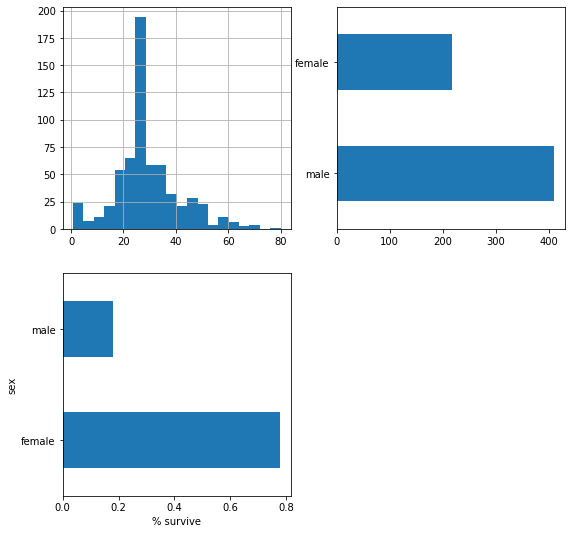

In [8]:
# Dataset 확인
print('Dataset 확인')
print(dftrain.head())
print()

# Label 확인
print('Label 확인')
print(y_train.head())
print()

# Dataset 상세 정보 확인(Numberic Feature들의 상세 정보를 출력해준다.)
print('Dataset 상세 정보 확인')
print(dftrain.describe())
print()

# Dataset Shape 확인
print('Datase Shape 확인')
print('Train Data Shape', dftrain.shape)
print('Test Data Shape', dfeval.shape)
print()

plt.figure(figsize=(9,9))
# Histogram 그리기
plt.subplot(221)
print('Age Histogram')
dftrain['age'].hist(bins=20)

# Plt 그리기
plt.subplot(222)
print('Sex Plot')
dftrain.sex.value_counts().plot(kind='barh')

# 조건으로서 Data Select하기
plt.subplot(223)
print('Selected Data Visualization')
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

#### Base Feature Columns
위에서 언급한 Feature Columns와 Input Function을 정의한다.  
크게 다음과 같은 2가지 방식으로서 Ipnput Data를 변형 시킨뒤 사용한다.  
- <code>tf.feature_column.numeric_column()</code>: Numeric Data는 tf.feature_column.numeric_columns를 활용하여 사용한다.
- <code>tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)</code>: Categorical Data는 One-Hot-Encoding으로서 변경한 뒤 사용한다.



In [9]:
# Feature_columns 설정
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Feature_columns 확인
print('Feature Columns')
for f_c in feature_columns:
    print(f_c)
print()


# Input Function 선언 => Batch + Epoch만큼 Dataset을 가져온다.
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

# Input Function Check
ds = make_input_fn(dftrain, y_train, batch_size=10)()
print('Input Function Check')
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())
print()

# Check Numeric Data Format After Data Preprocessing
print('Check Numeric Data(Age) Format After Data Preprocessing')
age_column = feature_columns[7]
print(tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy())
print()

# Check Categorical Data Format After Data Preprocessing
print('Check Categorical Data(Gender) Format After Data Preprocessing')
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

Feature Columns
VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.st

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

#### Model 생성 및 결과 확인
<code>tf.estimator.LinearClassifier()</code>를 활용하여 Model을 생성하고 결과를 확인한다.

In [10]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.8375268, 'auc_precision_recall': 0.7885603, 'average_loss': 0.47647125, 'label/mean': 0.375, 'loss': 0.4674509, 'precision': 0.7241379, 'prediction/mean': 0.33631855, 'recall': 0.6363636, 'global_step': 200}


### Create an Estimator form a Keras model
위에서 Estimator의 종류 중 하나로서 Keras Model도 소개하였다.  
이러한 Keras또한 Tensorflow에서 지원하는 <code>tf.estimator</code>를 사용하여 구성할 수 있다.  
<br>

#### Create a simple Keras model
간단한 Keras Model을 구성한다.

In [11]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(4,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


#### create an input function
Iris Dataset을 다운받고 Dict Type으로서 설정하는 과정을 거친다.

In [12]:
def input_fn():
    split = tfds.Split.TRAIN
    dataset = tfds.load('iris', split=split, as_supervised=True)
    dataset = dataset.map(lambda features, labels: ({'dense_input':features}, labels))
    dataset = dataset.batch(32).repeat()
    return dataset

# Chek Data
for features_batch, labels_batch in input_fn().take(1):
    print(features_batch)
    print(labels_batch)

{'dense_input': <tf.Tensor: id=6964, shape=(32, 4), dtype=float32, numpy=
array([[6.1, 2.8, 4.7, 1.2],
       [5.7, 3.8, 1.7, 0.3],
       [7.7, 2.6, 6.9, 2.3],
       [6. , 2.9, 4.5, 1.5],
       [6.8, 2.8, 4.8, 1.4],
       [5.4, 3.4, 1.5, 0.4],
       [5.6, 2.9, 3.6, 1.3],
       [6.9, 3.1, 5.1, 2.3],
       [6.2, 2.2, 4.5, 1.5],
       [5.8, 2.7, 3.9, 1.2],
       [6.5, 3.2, 5.1, 2. ],
       [4.8, 3. , 1.4, 0.1],
       [5.5, 3.5, 1.3, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.1, 3.8, 1.5, 0.3],
       [6.3, 3.3, 4.7, 1.6],
       [6.5, 3. , 5.8, 2.2],
       [5.6, 2.5, 3.9, 1.1],
       [5.7, 2.8, 4.5, 1.3],
       [6.4, 2.8, 5.6, 2.2],
       [4.7, 3.2, 1.6, 0.2],
       [6.1, 3. , 4.9, 1.8],
       [5. , 3.4, 1.6, 0.4],
       [6.4, 2.8, 5.6, 2.1],
       [7.9, 3.8, 6.4, 2. ],
       [6.7, 3. , 5.2, 2.3],
       [6.7, 2.5, 5.8, 1.8],
       [6.8, 3.2, 5.9, 2.3],
       [4.8, 3. , 1.4, 0.3],
       [4.8, 3.1, 1.6, 0.2],
       [4.6, 3.6, 1. , 0.2],
       [5.7, 4.4, 1.5, 0.4]

#### Create an Estimator form the tf.keras model
Keras Model을 <code>tf.keras.estimator.model_to_estimator</code>를 통하여 <code>tf.estimator</code>로서 변경하여 결과를 확인한다.  
결과 Directory를 확인하면 다음과 같다.  
**./Model/tfkeras_example/**  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Tensorflow/32.png" height="250" width="400" /></div><br>

**./Model/tfkeras_example/Keras**  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Tensorflow/33.png" height="250" width="400" /></div><br>
위에서 Keras -> Estimator로서 변경하였으므로 Keras Model을 사용할 수 있는 Folder와 Data 전처리 + Keras Model 인 Estimator를 사용할 수 있다.

In [13]:
model_dir = "./Model/tfkeras_example/"
keras_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model, model_dir=model_dir)

keras_estimator.train(input_fn=input_fn, steps=25)
eval_result = keras_estimator.evaluate(input_fn=input_fn, steps=10)
print('Eval result: {}'.format(eval_result))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using config: {'_model_dir': './Model/tfkeras_example/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f95f0de4c10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './Model/tfkeras_example/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f95f0de4c10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./Model/tfkeras_example/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./Model/tfkeras_example/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting from: ./Model/tfkeras_example/keras/keras_model.ckpt


INFO:tensorflow:Warm-starting from: ./Model/tfkeras_example/keras/keras_model.ckpt


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-started 4 variables.


INFO:tensorflow:Warm-started 4 variables.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./Model/tfkeras_example/model.ckpt-50


INFO:tensorflow:Restoring parameters from ./Model/tfkeras_example/model.ckpt-50


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 50 into ./Model/tfkeras_example/model.ckpt.


INFO:tensorflow:Saving checkpoints for 50 into ./Model/tfkeras_example/model.ckpt.


INFO:tensorflow:loss = 109.38061, step = 50


INFO:tensorflow:loss = 109.38061, step = 50


INFO:tensorflow:Saving checkpoints for 75 into ./Model/tfkeras_example/model.ckpt.


INFO:tensorflow:Saving checkpoints for 75 into ./Model/tfkeras_example/model.ckpt.


INFO:tensorflow:Loss for final step: 84.006805.


INFO:tensorflow:Loss for final step: 84.006805.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-28T13:48:31Z


INFO:tensorflow:Starting evaluation at 2019-12-28T13:48:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./Model/tfkeras_example/model.ckpt-75


INFO:tensorflow:Restoring parameters from ./Model/tfkeras_example/model.ckpt-75


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2019-12-28-13:48:31


INFO:tensorflow:Finished evaluation at 2019-12-28-13:48:31


INFO:tensorflow:Saving dict for global step 75: global_step = 75, loss = 100.03222


INFO:tensorflow:Saving dict for global step 75: global_step = 75, loss = 100.03222


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 75: ./Model/tfkeras_example/model.ckpt-75


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 75: ./Model/tfkeras_example/model.ckpt-75


Eval result: {'loss': 100.03222, 'global_step': 75}


**Estimator 사용 결과 Keras에 익숙해져 있어서 인지 Keras가 더 편하고 자주 사용할 거이라고 생각된다...**